In [1]:
import cv2
import numpy as np
import time
import argparse


import matplotlib.pyplot as plt

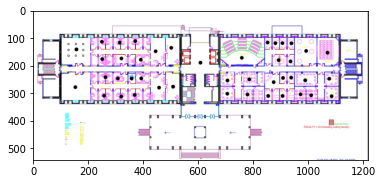

In [2]:
img_top=cv2.imread('task3.jpg')
H1=np.load('HnpCopy.npy')
H2=np.load('HnpCopy.npy')
H3=np.load('HnpCopy.npy')
plt.imshow(img_top)


In [3]:
print(img_top)

[[[183 180 226]
  [245 244 255]
  [248 253 255]
  ...
  [246 247 255]
  [159 162 243]
  [138 141 250]]

 [[183 180 226]
  [245 244 255]
  [248 253 255]
  ...
  [246 247 255]
  [159 162 243]
  [138 141 250]]

 [[183 180 226]
  [245 244 255]
  [248 253 255]
  ...
  [246 247 255]
  [159 162 243]
  [138 141 250]]

 ...

 [[183 180 226]
  [245 244 255]
  [248 253 255]
  ...
  [246 247 255]
  [159 162 243]
  [138 141 250]]

 [[183 180 226]
  [245 244 255]
  [248 253 255]
  ...
  [246 247 255]
  [159 162 243]
  [138 141 250]]

 [[183 180 226]
  [245 244 255]
  [248 253 255]
  ...
  [246 247 255]
  [159 162 243]
  [138 141 250]]]


In [4]:
net = cv2.dnn.readNet("yolov3.weights","yolov3.cfg")
classesFile = "coco.names";
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

In [5]:
layer_names = net.getLayerNames()
outputlayers = [layer_names[[i][0] - 1] for i in net.getUnconnectedOutLayers()]

In [6]:
colors= np.random.uniform(0,255,size=(len(classes),3))

In [7]:
def box(blob,frame,font):
                height,width,channels = frame.shape
                net.setInput(blob)
                outs = net.forward(outputlayers)
                class_ids=[]
                confidences=[]
                boxes=[]
                person_boxes=[]
                for out in outs:
                    for detection in out:
                        scores = detection[5:]
                        class_id = np.argmax(scores)
                        confidence = scores[class_id]
                        #print("confidence",confidence)
                        if confidence > 0.3:

                            center_x= int(detection[0]*width)
                            center_y= int(detection[1]*height)
                            w = int(detection[2]*width)
                            h = int(detection[3]*height)
                            x=int(center_x - w/2)
                            y=int(center_y - h/2)


                            boxes.append([x,y,w,h]) 
                            confidences.append(float(confidence)) 
                            class_ids.append(class_id) 
                
                indexes = cv2.dnn.NMSBoxes(boxes,confidences,0.3,0.4)
                
                for i in range(len(boxes)):
                    if i in indexes and class_ids[i]==0:
                        print ("Person is detected")
                        x,y,w,h = boxes[i]
                        #label = str(classes[class_ids[i]])
                        #confidence= confidences[i]
                        #color = colors[class_ids[i]]
                        #cv2.rectangle(frame,(x,y),(x+w,y+h),color,2)
                        #cv2.putText(frame,label+" "+str(round(confidence,2)),(x,y+30),font,1,(255,255,255),2)
                        #cv2.circle(frame, (int(x),int(y)), radius=20, color=(0, 0, 255), thickness=-1)
                        person_boxes.append([int((x)),int(y),1])
                        
                        
                return person_boxes

In [9]:
def offline_mode(filename1,filename2,filename3,maxx):
        #reading files
        cap_1=cv2.VideoCapture(filename1)
        cap_2=cv2.VideoCapture(filename2)
        cap_3=cv2.VideoCapture(filename3) 
        font = cv2.FONT_HERSHEY_PLAIN
        starting_time= time.time()
        frame_id = 0
        #Writing to files
        frame_width_1 = int(cap_1.get(3)) 
        frame_height_1 = int(cap_1.get(4))
        size_1=(frame_width_1,frame_height_1)

        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        wrt_1= cv2.VideoWriter('BoxedVideo/Offline/IpWeb_1.avi',fourcc, 20.0, (img_top.shape[1],img_top.shape[0])) 
        
        k=21
        gauss=cv2.getGaussianKernel(k,np.sqrt(64))
        gauss=gauss*gauss.T
        gauss=(gauss/gauss[int(k/2),int(k/2)])
        j=cv2.cvtColor(cv2.applyColorMap(((gauss)*255).astype(np.uint8),cv2.COLORMAP_SPRING),cv2.COLOR_BGR2RGB).astype(np.float32)/255
        boxes_points=[]
        while True:
            
            ret_1,frame_1=cap_1.read()  
            ret_2,frame_2=cap_2.read()
            ret_3,frame_3=cap_3.read()
            if   ret_1==True and ret_2==True and ret_3==True:
                frame_id+=1
                

                blob1 = cv2.dnn.blobFromImage(frame_1,0.00392,(320,320),(0,0,0),True,crop=False)   
                blob2 = cv2.dnn.blobFromImage(frame_2,0.00392,(320,320),(0,0,0),True,crop=False)     
                blob3 = cv2.dnn.blobFromImage(frame_3,0.00392,(320,320),(0,0,0),True,crop=False)         
                person_boxes1=box(blob1,frame_1,font)
                person_boxes2=box(blob2,frame_2,font)
                person_boxes3=box(blob3,frame_3,font)
                    
                output_frame1 = cv2.warpPerspective(frame_1, H1, (img_top.shape[1],img_top.shape[0]))
                output_frame2 = cv2.warpPerspective(frame_2, H2, (img_top.shape[1],img_top.shape[0]))
                output_frame3 = cv2.warpPerspective(frame_3, H3, (img_top.shape[1],img_top.shape[0]))
                a=output_frame1/255.0
                b=output_frame2/255.0
                c=output_frame3/255.0
                output_frame=np.where((a>0 )& (b>0) & (c>0),(a+b+c)/3,np.where((a==0 )& (b>0) & (c>0),(b+c)/2,np.where((a>0 )& (b==0) & (c>0),(a+c)/2,np.where((a>0 )& (b>0) & (c==0),(a+b)/2,np.where((a==0 )& (b==0) & (c>0),c,np.where((a>0 )& (b==0) & (c==0),a,np.where((a==0 )& (b>0) & (c==0),b,0)))))))
                 
                person_boxes1=np.array(person_boxes1)
                person_boxes1=np.transpose(person_boxes1)
                if (len(person_boxes1)!=0):
                    person_boxes1=np.dot(H1,person_boxes1)
                    person_boxes1=np.transpose(person_boxes1)    
                    person_boxes1=list(person_boxes1) 
                    boxes_points.extend(person_boxes1)
                    if maxx>0 :
                         boxes_points =boxes_points[-maxx:]
                        
                        
                
                person_boxes2=np.array(person_boxes2)
                person_boxes2=np.transpose(person_boxes2)
                if (len(person_boxes2)!=0):
                    person_boxes2=np.dot(H2,person_boxes2)
                    person_boxes2=np.transpose(person_boxes2)    
                    person_boxes2=list(person_boxes2)   
                    boxes_points.extend(person_boxes2)
                    if maxx>0 :
                         boxes_points =boxes_points[-maxx:]
                    
                person_boxes3=np.array(person_boxes3)
                person_boxes3=np.transpose(person_boxes3)
                if (len(person_boxes3)!=0):
                    person_boxes3=np.dot(H3,person_boxes3)
                    person_boxes3=np.transpose(person_boxes3)    
                    person_boxes3=list(person_boxes3)   
                    boxes_points.extend(person_boxes3)
                    if maxx>0 :
                         boxes_points =boxes_points[-maxx:]
                
                img2=np.zeros((img_top.shape[0],img_top.shape[1],3)).astype(np.float32)
                heatmap=output_frame
                
                print ("Number of points",len(boxes_points))
                if (len(boxes_points)!=0):
                    for p in boxes_points:
                        #print (p)
                        p=p/p[2]
                        b=img2[int(p[1])-int(k/2):int(p[1])+int(k/2)+1,int(p[0])-int(k/2):int(p[0])+int(k/2)+1,:]
                        c=j+b
                        img2[int(p[1])-int(k/2):int(p[1])+int(k/2)+1,int(p[0])-int(k/2):int(p[0])+int(k/2)+1,:]=c
                    m=np.max(img2,axis=(0,1))+0.0001
                    img2=img2/m  
                
                    g=cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY)
                    mask=np.where(g>0.1,1,0).astype(np.float32)
                    mask3=np.ones((img_top.shape[0],img_top.shape[1],3))*(1-mask)[:,:,None]
                    mask4=img2*(mask)[:,:,None]
                    new_img=mask3*output_frame
                    
                    heatmap=new_img+mask4
                cv2.putText(heatmap,"Frame id "+ " "+str(frame_id),(10,10),font,1,(255,255,255),2)
                cv2.imshow("OUTPUT", heatmap) 
                
                
                plt.imshow(new_img)
                #output_frame=np.uint8(255 * heatmap)  
                output_frame = np.clip(heatmap * 255, 0, 255)
                output_frame = output_frame.astype(np.uint8)
                wrt_1.write(output_frame)
                key = cv2.waitKey(1) 
                
                if key == 27:
                    break;
            else :
                break
        cap_1.release()
        cap_2.release()
        cap_3.release()
        wrt_1.release()

        cv2.destroyAllWindows()

Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Number of points 9
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Number of points 18
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Number of points 27
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Number of points 36
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Number of points 45
Person is detected
Person is detected
Person i

Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Number of points 399
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Person is detected
Number of points 411


ValueError: operands could not be broadcast together with shapes (21,21,3) (21,0,3) 

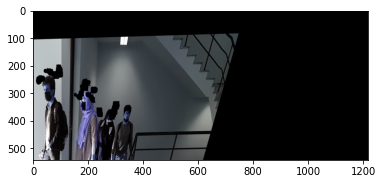

In [10]:
offline_mode("feed.mp4","feed.mp4","feed.mp4",maxx=-1)

In [9]:
def online_mode(maxx):
   # url_1='http://192.168.1.106:8080/video'
   # url_2=0
   # url_3='http://192.168.1.101:8080/video'
   # url_1="IpWeb_1.avi"
   # url_2="IpWeb_2.avi"
   # url_3="IpWeb_3.avi"
   # cap_1=cv2.VideoCapture(url_1)
   # cap_2=cv2.VideoCapture(url_2)
   # cap_3=cv2.VideoCapture(url_3)
    
    cap_1=cv2.VideoCapture(0)
    cap_2=cap_1
    cap_3=cap_2
    
    
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    wrt_1= cv2.VideoWriter('BoxedVideo/Online/IpWeb_1.avi',fourcc, 20.0, (img_top.shape[1],img_top.shape[0]))
    if cap_1.isOpened()==False:
        print ("Unable to Connect to Ip Webcam # 1")
    elif cap_2.isOpened()==False:
        print ("Unable to Connect to Ip Webcam # 2")
    elif cap_3.isOpened()==False:
        print ("Unable to Connect to Ip Webcam # 3")    
    else:
        
        font = cv2.FONT_HERSHEY_PLAIN
        starting_time= time.time()
        frame_id = 0
        k=21
        gauss=cv2.getGaussianKernel(k,np.sqrt(64))
        gauss=gauss*gauss.T
        gauss=(gauss/gauss[int(k/2),int(k/2)])
        j=cv2.cvtColor(cv2.applyColorMap(((gauss)*255).astype(np.uint8),cv2.COLORMAP_SPRING),cv2.COLOR_BGR2RGB).astype(np.float32)/255
        boxes_points=[]
        while True:

            ret_1,frame_1=cap_1.read()  
            ret_2,frame_2=cap_2.read()
            ret_3,frame_3=cap_3.read()
            if   ret_1==True and ret_2==True and ret_3==True:
                frame_id+=1
                

                blob1 = cv2.dnn.blobFromImage(frame_1,0.00392,(320,320),(0,0,0),True,crop=False)   
                blob2 = cv2.dnn.blobFromImage(frame_2,0.00392,(320,320),(0,0,0),True,crop=False)     
                blob3 = cv2.dnn.blobFromImage(frame_3,0.00392,(320,320),(0,0,0),True,crop=False)         
                person_boxes1=box(blob1,frame_1,font)
                person_boxes2=box(blob2,frame_2,font)
                person_boxes3=box(blob3,frame_3,font)
                    
                output_frame1 = cv2.warpPerspective(frame_1, H1, (img_top.shape[1],img_top.shape[0]))
                output_frame2 = cv2.warpPerspective(frame_2, H2, (img_top.shape[1],img_top.shape[0]))
                output_frame3 = cv2.warpPerspective(frame_3, H3, (img_top.shape[1],img_top.shape[0]))
                a=output_frame1/255.0
                b=output_frame2/255.0
                c=output_frame3/255.0
                output_frame=np.where((a>0 )& (b>0) & (c>0),(a+b+c)/3,np.where((a==0 )& (b>0) & (c>0),(b+c)/2,np.where((a>0 )& (b==0) & (c>0),(a+c)/2,np.where((a>0 )& (b>0) & (c==0),(a+b)/2,np.where((a==0 )& (b==0) & (c>0),c,np.where((a>0 )& (b==0) & (c==0),a,np.where((a==0 )& (b>0) & (c==0),b,0)))))))
               
                person_boxes1=np.array(person_boxes1)
                person_boxes1=np.transpose(person_boxes1)
                if (len(person_boxes1)!=0):
                    person_boxes1=np.dot(H1,person_boxes1)
                    person_boxes1=np.transpose(person_boxes1)    
                    person_boxes1=list(person_boxes1) 
                    boxes_points.extend(person_boxes1)
                    if maxx>0 :
                         boxes_points =boxes_points[-maxx:]
                        
                        
                
                person_boxes2=np.array(person_boxes2)
                person_boxes2=np.transpose(person_boxes2)
                if (len(person_boxes2)!=0):
                    person_boxes2=np.dot(H2,person_boxes2)
                    person_boxes2=np.transpose(person_boxes2)    
                    person_boxes2=list(person_boxes2)   
                    boxes_points.extend(person_boxes2)
                    if maxx>0 :
                         boxes_points =boxes_points[-maxx:]
                    
                person_boxes3=np.array(person_boxes3)
                person_boxes3=np.transpose(person_boxes3)
                if (len(person_boxes3)!=0):
                    person_boxes3=np.dot(H3,person_boxes3)
                    person_boxes3=np.transpose(person_boxes3)    
                    person_boxes3=list(person_boxes3)   
                    boxes_points.extend(person_boxes3)
                    if maxx>0 :
                         boxes_points =boxes_points[-maxx:]
                
                img2=np.zeros((img_top.shape[0],img_top.shape[1],3)).astype(np.float32)
                heatmap=output_frame
                
                print ("Number of points",len(boxes_points))
                if (len(boxes_points)!=0):
                    for p in boxes_points:
                        #print (p)
                        p=p/p[2]
                        b=img2[int(p[1])-int(k/2):int(p[1])+int(k/2)+1,int(p[0])-int(k/2):int(p[0])+int(k/2)+1,:]
                        c=j+b
                        img2[int(p[1])-int(k/2):int(p[1])+int(k/2)+1,int(p[0])-int(k/2):int(p[0])+int(k/2)+1,:]=c
                    m=np.max(img2,axis=(0,1))+0.0001
                    img2=img2/m  
                
                    g=cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY)
                    mask=np.where(g>0.1,1,0).astype(np.float32)
                    mask3=np.ones((img_top.shape[0],img_top.shape[1],3))*(1-mask)[:,:,None]
                    mask4=img2*(mask)[:,:,None]
                    new_img=mask3*output_frame
                    
                    heatmap=new_img+mask4
                cv2.putText(heatmap,"Frame id "+ " "+str(frame_id),(10,10),font,1,(255,255,255),2)
                cv2.imshow("OUTPUT", heatmap)  
                output_frame = np.clip(heatmap * 255, 0, 255)
                output_frame = output_frame.astype(np.uint8)  
                wrt_1.write(output_frame)
                key = cv2.waitKey(1) 
                
                if key == 27:
                    break;
            else :
                break
    cap_1.release()
    cap_2.release()
    cap_3.release()
    wrt_1.release()

    cv2.destroyAllWindows()

In [10]:
online_mode(maxx=-1)

Number of points 0
Number of points 0
Person is detected
Person is detected
Person is detected
Number of points 3
Person is detected
Person is detected
Person is detected
Number of points 6
Person is detected
Person is detected
Person is detected
Number of points 9
Person is detected
Person is detected
Person is detected
Number of points 12
Person is detected
Person is detected
Person is detected
Number of points 15
Person is detected
Person is detected
Person is detected
Number of points 18
Person is detected
Person is detected
Person is detected
Number of points 21
Person is detected
Person is detected
Person is detected
Number of points 24
Person is detected
Person is detected
Person is detected
Number of points 27
Person is detected
Person is detected
Person is detected
Number of points 30
Person is detected
Person is detected
Person is detected
Number of points 33
Person is detected
Person is detected
Person is detected
Number of points 36
Person is detected
Person is detected
Per

KeyboardInterrupt: 